# XGBoost implementation for Time series forecasting in stock prices

In [ ]:
pip install xgboost

## Libraries

In [3]:
import pandas as pd 
import IPython
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import xgboost as sgb

## Data preprocessing

In [4]:
IPython.display.IFrame(src="https://www.kaggle.com/embed/zhipengsun964/ga-python-finalproject?cellIds=5&kernelSessionId=150910453", width = "950px", height="300")

The initial hypothesis is that we need to take a look at the fields related to the stock prices and trading sales. In order to analyze if the prices seem to be relevant in the trading volume

In [39]:
df = pd.read_csv('SP500.csv')
df

,date,open,high,low,close,volume,change_percent,avg_vol_20d
0,1927-12-30,17.6600,17.6600,17.6600,17.6600,0,NaN,NaN
1,1928-01-03,17.7600,17.7600,17.7600,17.7600,0,0.57,NaN
2,1928-01-04,17.7200,17.7200,17.7200,17.7200,0,-0.23,NaN
3,1928-01-05,17.5500,17.5500,17.5500,17.5500,0,-0.96,NaN
4,1928-01-06,17.6600,17.6600,17.6600,17.6600,0,0.63,NaN
...,...,...,...,...,...,...,...,...
24084,2023-11-15,4505.2998,4521.1699,4495.3101,4502.8799,4347170000,0.16,4.024057e+09
24085,2023-11-16,4497.0801,4511.9902,4487.8301,4508.2402,3964520000,0.12,4.023796e+09
24086,2023-11-17,4509.5498,4520.1201,4499.6602,4514.0200,3777240000,0.13,4.012457e+09
24087,2023-11-20,4511.7002,4557.1099,4510.3599,4547.3799,3644790000,0.74,4.005892e+09


By only using the data from the 2000s up to today, we can also look at how the economic crisis from 2008 and 2020 affected the prices and sales. By this means, we'll be able to have a much clearer view on how these stocks behave.

In [40]:
# Filter by date
df = df[~(df['date'] < '2000-01-01')]
df

,date,open,high,low,close,volume,change_percent,avg_vol_20d
18078,2000-01-03,1469.2500,1478.0000,1438.3600,1455.2200,931800000,-0.95,8.890695e+08
18079,2000-01-04,1455.2200,1455.2200,1397.4301,1399.4200,1009000000,-3.83,8.936795e+08
18080,2000-01-05,1399.4200,1413.2700,1377.6801,1402.1100,1085500000,0.19,8.936645e+08
18081,2000-01-06,1402.1100,1411.9000,1392.1000,1403.4500,1092300000,0.10,9.004295e+08
18082,2000-01-07,1403.4500,1441.4700,1400.7300,1441.4700,1225200000,2.71,9.055845e+08
...,...,...,...,...,...,...,...,...
24084,2023-11-15,4505.2998,4521.1699,4495.3101,4502.8799,4347170000,0.16,4.024057e+09
24085,2023-11-16,4497.0801,4511.9902,4487.8301,4508.2402,3964520000,0.12,4.023796e+09
24086,2023-11-17,4509.5498,4520.1201,4499.6602,4514.0200,3777240000,0.13,4.012457e+09
24087,2023-11-20,4511.7002,4557.1099,4510.3599,4547.3799,3644790000,0.74,4.005892e+09


Set the 'date' field as an index and making sure it is a datetime and not a string for plotting purposes

In [41]:
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

#### Plot Variables

In [42]:
def plotVariables(df,vars, title):
    df[vars].plot(
        figsize=(15,7), 
        title=title,
        subplots = True
    )

    plt.show()

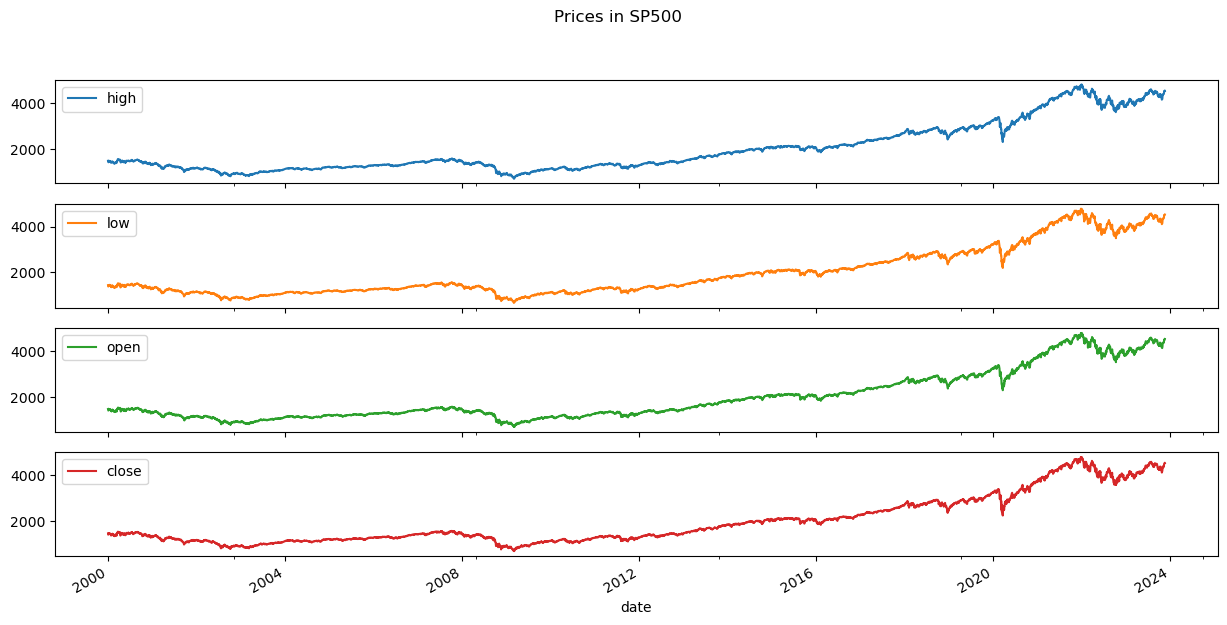

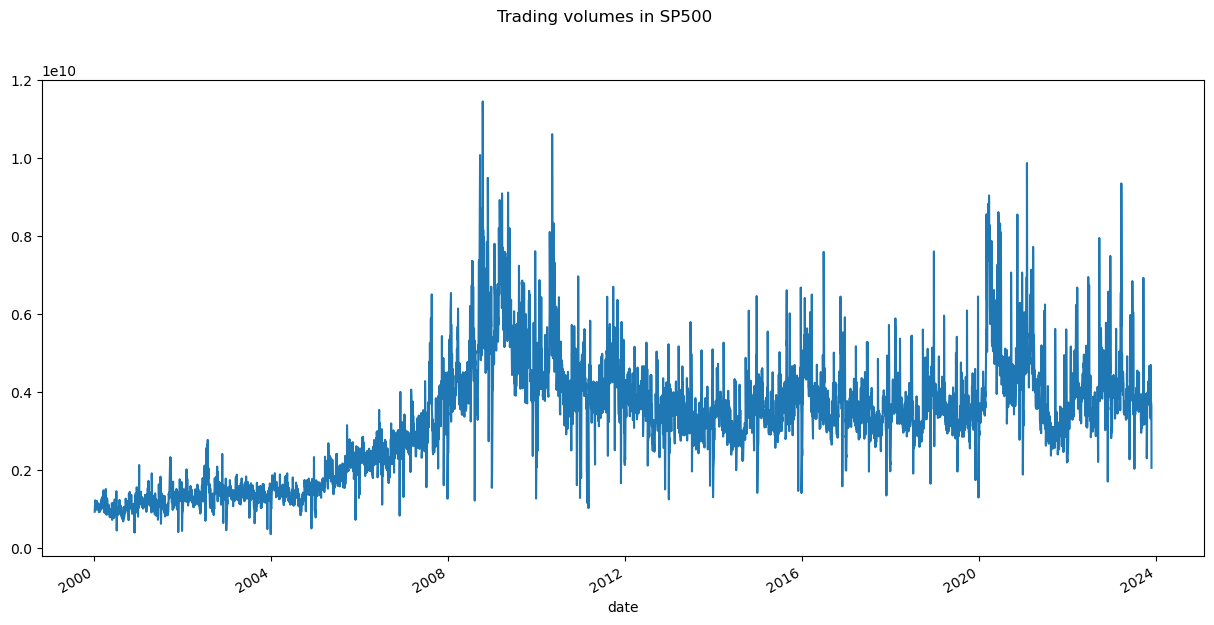

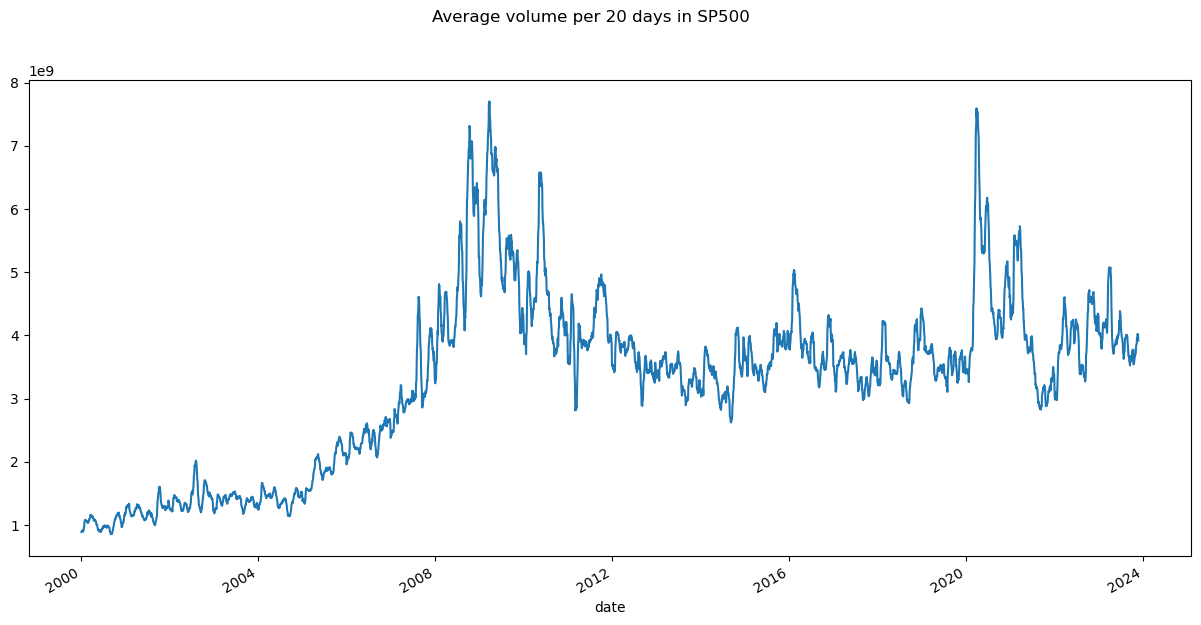

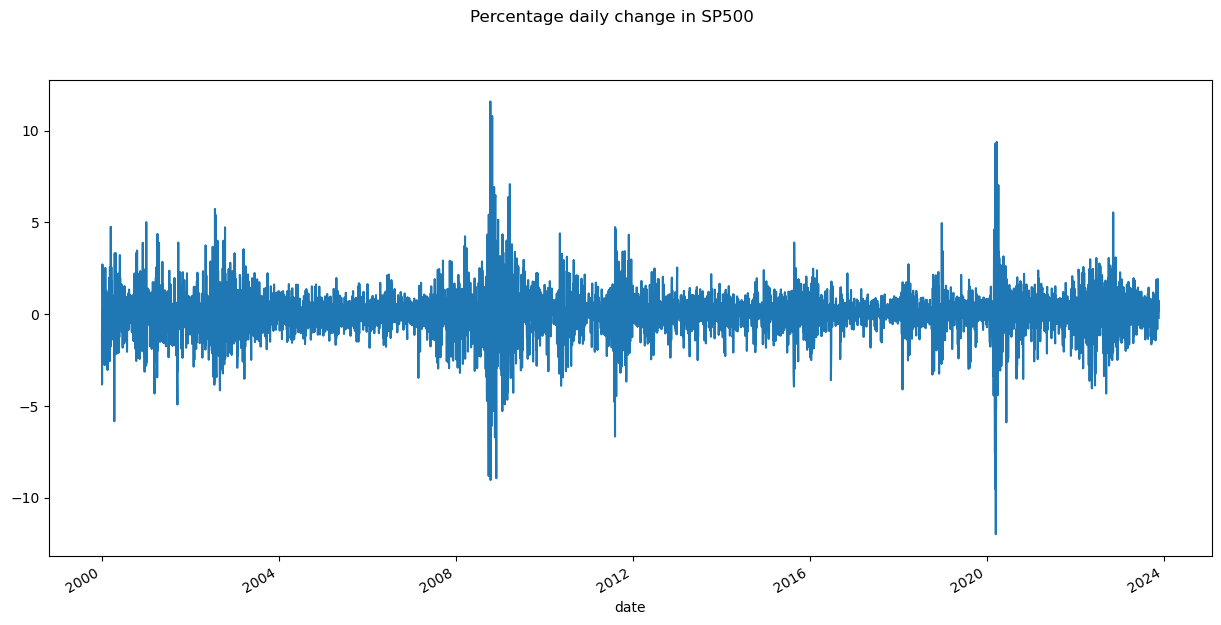

In [43]:
plotVariables(df,['high','low','open','close'],'Prices in SP500')
plotVariables(df,'volume','Trading volumes in SP500')
plotVariables(df,'avg_vol_20d','Average volume per 20 days in SP500')
plotVariables(df,'change_percent','Percentage daily change in SP500')

## Split dataset to train and test

Separate out dataset into 2, one for training our model and the other to test the time series forecasting we'll do later.

In [44]:
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

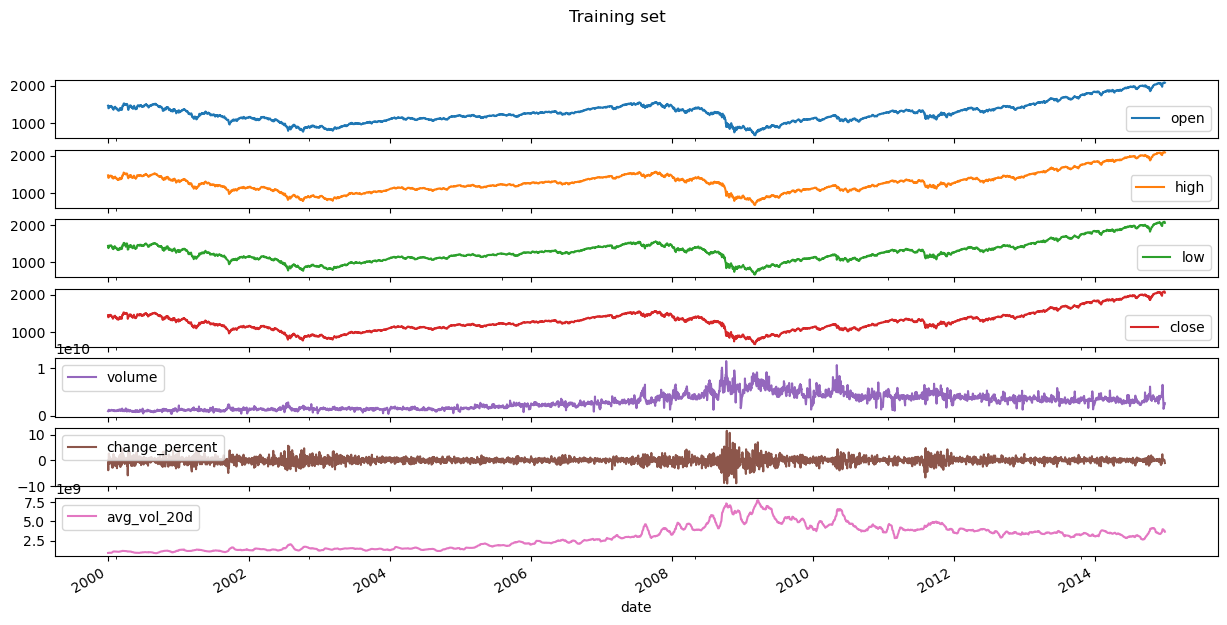

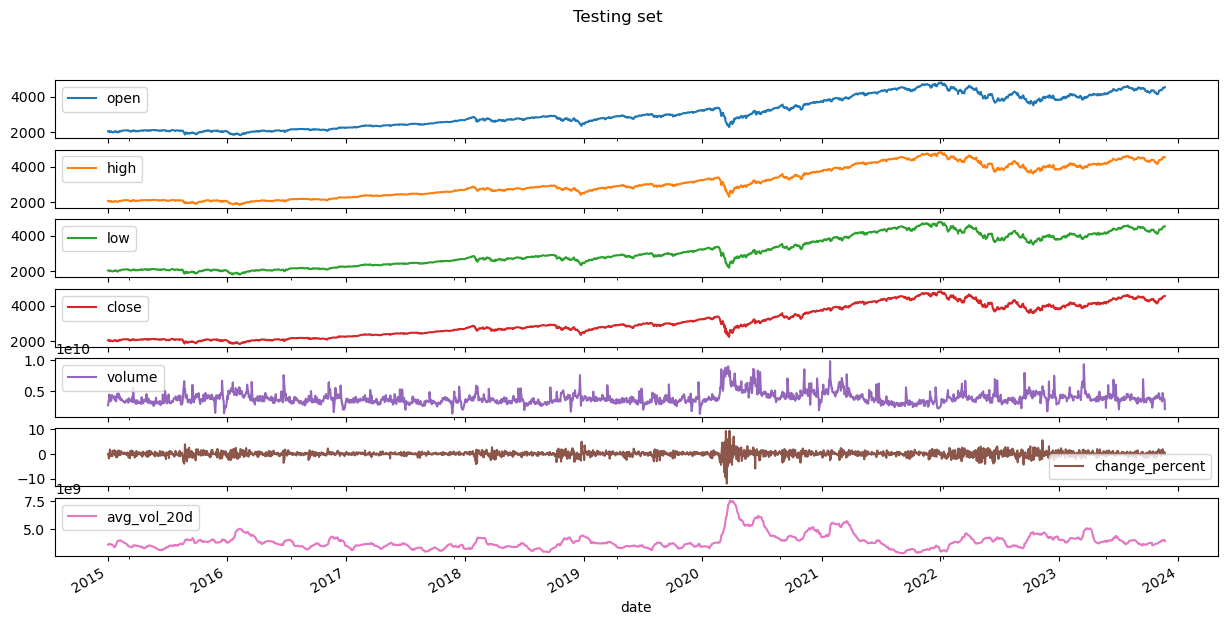

In [45]:
plotVariables(train,list(train.columns.values),'Training set')
plotVariables(test,list(test.columns.values),'Testing set')

We can clearly see in both training and testing splits that there are evident trading volume variations based on the price of the stocks. Particularly we can observe in between 2008 and 2010 for the training set, this matches with the 2008's economic crisis which caused stock prices to lower and by consecuence having an increase in byuer transactions. We can see this phenomenon also happen in between 2020 and 2021 probably due to the Covid-19 crisis. These case show us a direct realtion between stock prices, trade volumes and average 20 day trading volumes.

We van also observe that both of these cases also cause a the daily percent change in the prices to ve a lot broader.

## Feature creation

The next step is to create the necessary features for defining the stock's performance and forecast this same metric. Since we have an datetime index we can break this data into its components such as:

- Year
- Month
- Quarter

In order to get an easier view of the data and how did the stocks performed in different periods of time. 

Also we will calculate the Logarithmic returns of the closing prices of these stocks, this is a metric that returns a decimal that we can turn into a percentage. It indicates the performance of the stock and they are additive over time for further analysis. 


\begin{align*}

R = ln (\frac{P_t}{P_{t-1}}) \\
\end{align*}

In [59]:
def addFeatures(df):
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month_name()
    df['year'] = df.index.year
    df['log_ret'] = np.log(df['close']/df['close'].shift(1)) * 100
    return df

In [60]:
df = addFeatures(df)
df

,open,high,low,close,volume,change_percent,avg_vol_20d,month,year,log_ret,quarter
date,,,,,,,,,,,
2000-01-03,1469.2500,1478.0000,1438.3600,1455.2200,931800000,-0.95,8.890695e+08,January,2000,NaN,1
2000-01-04,1455.2200,1455.2200,1397.4301,1399.4200,1009000000,-3.83,8.936795e+08,January,2000,-3.909923,1
2000-01-05,1399.4200,1413.2700,1377.6801,1402.1100,1085500000,0.19,8.936645e+08,January,2000,0.192038,1
2000-01-06,1402.1100,1411.9000,1392.1000,1403.4500,1092300000,0.10,9.004295e+08,January,2000,0.095525,1
2000-01-07,1403.4500,1441.4700,1400.7300,1441.4700,1225200000,2.71,9.055845e+08,January,2000,2.672994,1
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-15,4505.2998,4521.1699,4495.3101,4502.8799,4347170000,0.16,4.024057e+09,November,2023,0.159574,4
2023-11-16,4497.0801,4511.9902,4487.8301,4508.2402,3964520000,0.12,4.023796e+09,November,2023,0.118971,4
2023-11-17,4509.5498,4520.1201,4499.6602,4514.0200,3777240000,0.13,4.012457e+09,November,2023,0.128123,4


#### Display the addition of log returns per year and quarter

In [73]:
added_logreturn_quarter = df.groupby(['year','quarter'])['log_ret'].sum()
added_logreturn_year = df.groupby('year')['log_ret'].sum()

Text(0, 0.5, 'Sum of Log Returns')

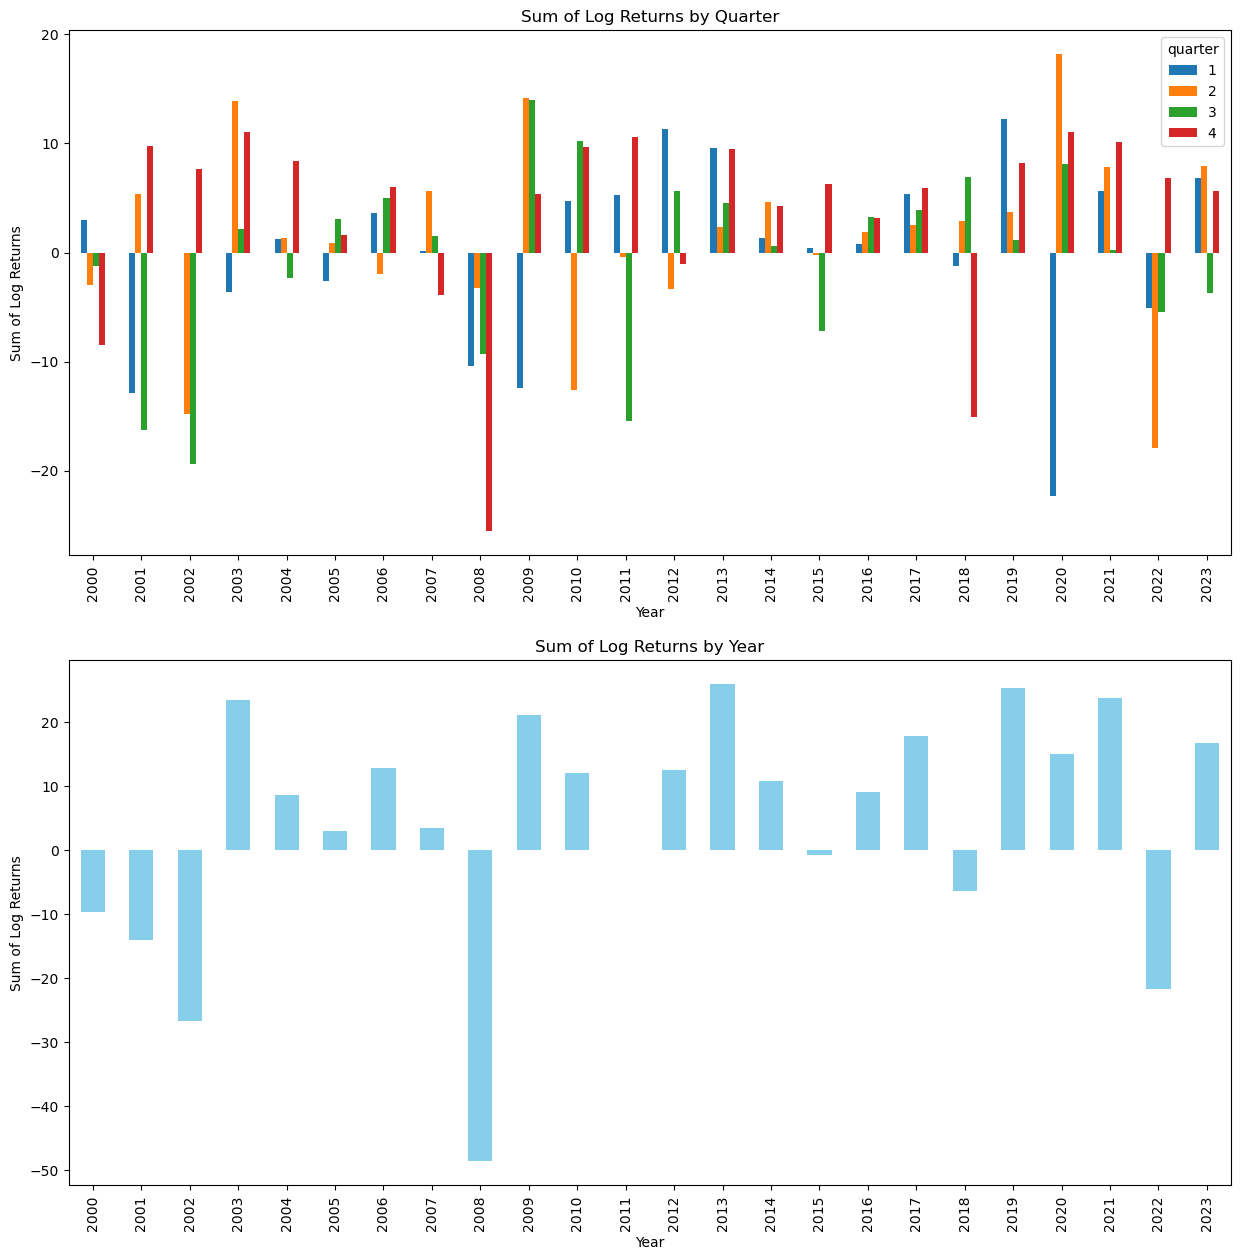

In [81]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15),)

# Plot for added_logreturn_quarter
added_logreturn_quarter.unstack().plot(kind='bar', ax=axes[0])
axes[0].set_title('Sum of Log Returns by Quarter')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Sum of Log Returns')

# Plot for added_logreturn_year
added_logreturn_year.plot(kind='bar', ax=axes[1], color='skyblue')
axes[1].set_title('Sum of Log Returns by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Sum of Log Returns')

## Create out model